# HOMEWORK 11

In this homework you are going to improve the DNN for house price estimation we built during the lesson. The objective is to beat the performance (i.e. to get a closer estimation) of the last network we built in the lecture.

The structure of this homework is as follows:
 * First, we are going to build the reference network (exactly the same network we implemented in the lecture).
 * You are going to run it a write down the price estimation error (Validation MAE).
 * Then you are going to make some modifications in order to make the network perform better.
 
In the section **Tasks** you will find what modification you'll need to implement as well as some hints.
 
At the end, as usual, there are some question waiting for you to answer :-)

In [1337]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from tensorflow.keras import Model, metrics
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Set the seeds
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Data Preparation

Let's load the data and prepare the training sets.

In [1338]:
data_path = os.getcwd() + '\datasets\kaggle\house-prices-advanced-regression-techniques\\train.csv'
# print(f'Reading data from "{data_path}"')
dataset = pd.read_csv(data_path)

features_numbers = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt', 
            'LotArea', 'OverallCond', 'BedroomAbvGr', '3SsnPorch', 'PoolArea', 'GarageArea', 'WoodDeckSF',
            ]

# values of these columns must be additionally processed text_label -> number
features_labels = ['CentralAir', 'ExterCond', 'Exterior1st', 'BldgType', 'Neighborhood', 'Utilities', 
                   'KitchenQual', 'PoolQC', 'GarageType', 'YrSold', 'FireplaceQu', 'GarageFinish']

data_numbers = dataset[features_numbers]

data_all = data_numbers.copy()

lb = LabelEncoder()

for label in features_labels:
    lb_result = lb.fit_transform(dataset[label])
    data_all.loc[:, label] = lb_result.tolist()
    
# Filling nan with the mean of the column:
data_all = data_all.fillna(data_all.mean())

# Extract input values and normalize
x = data_all[features_numbers[1:] + features_labels]

# print(x[:5])

scale = StandardScaler()
x = scale.fit_transform(x)

# print(x[:5])


# Extract output values (prices) and normalize
y = data_all[features[0]].values
y = y/100000

# Split into 75% for train and 25% for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed_value)

Let's use the same plotting helper we used in the lecture.

In [1339]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, np.array(h['mean_absolute_error'])*1e5, '.-',
                               epochs, np.array(h['val_mean_absolute_error'])*1e5, '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'])
        
    print('Train MAE     ', h['mean_absolute_error'][-1]*1e5)
    print('Validation MAE', h['val_mean_absolute_error'][-1]*1e5)

### Building the Network

In [1340]:
inputs = Input(shape=x.shape[1])

outputs = Dense(256, activation='relu')(inputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(32, activation='relu')(outputs)
outputs = Dense(1, activation='linear')(outputs)
model = Model(inputs, outputs)

model.compile(optimizer = Adam(learning_rate=0.001), loss ='mean_squared_error', metrics =[metrics.mae])
model.summary()

Model: "functional_519"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_260 (InputLayer)       [(None, 24)]              0         
_________________________________________________________________
dense_798 (Dense)            (None, 256)               6400      
_________________________________________________________________
dense_799 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_800 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_801 (Dense)            (None, 1)                 33        
Total params: 43,457
Trainable params: 43,457
Non-trainable params: 0
_________________________________________________________________


### Training the Network

Train MAE      6140.580400824547
Validation MAE 18587.31061220169


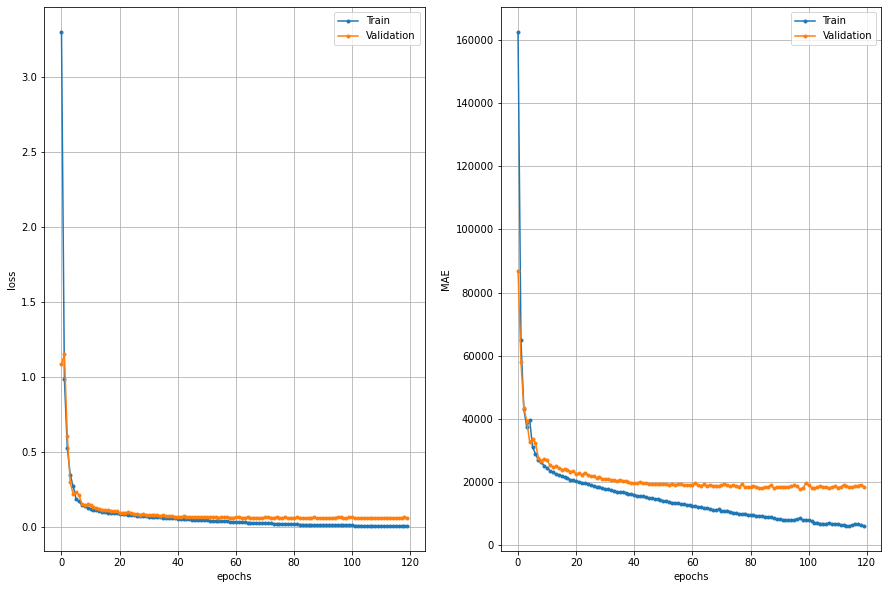

In [1341]:
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=120, batch_size=200, verbose=0)
plot_history(history)

### Tasks

Improve the network so you obtain a better estimation error than the reference. You can try the following:
* Add a new feature to your inputs. For instance, `LotArea` (lot size in square feet) seems like a good candidate :-)
* Try increasing the number of neurons in the first layer. Currently, we have 5 neurons there, what happens if we increase it to 10?

### Questions
* What is the new price estimation error after your modifrications? Is it better than before?
* Does adding more features help?
* Does adding more neurons help?
* What would you do to improv the network even further?

### Answers
* It is better. More neurons, typically, give better results. However, many other parameters affect prediction quality, so changing five neurons to 10 won't give much of the difference. The more neurons we have, the fewer epochs we need to train (from my observation), otherwise, the errors level raises
* Depends on the feature, some of them improve results while some others - worsen them
* In general - yes
* I've changed many settings. See the code for the final results. I feel that, somehow, validation data are different from training data (probably by coincidence) because I'm getting good results for Training MAE and much worse outcomes for Validation MAE. By default, the amount of validation data is 25%. If I change it to 10% or even less, I can get better validation MAE with unchanged other parameters. I guess if we had around 100000 rows (much more than we have) in a database, we would get better general results
